## Importing and vizualising Data

In [1]:
import pandas as pd

df = pd.read_csv('sms_spam.csv', header = 0, names = ['Label', 'Asunto'])
print(df.shape)
df.head()

(5559, 2)


,Label,Asunto
0,ham,Hope you are having a good week. Just checking in
1,ham,K..give back my thanks.
2,ham,Am also doing in cbe only. But have to pay.
3,spam,"complimentary 4 STAR Ibiza Holiday or £10,000 ..."
4,spam,okmail: Dear Dave this is your final notice to...


In [2]:
df['Label'].value_counts(normalize = True)

ham     0.865623
spam    0.134377
Name: Label, dtype: float64

Word Cloud

In [3]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
%matplotlib inline

Spam Word Cloud


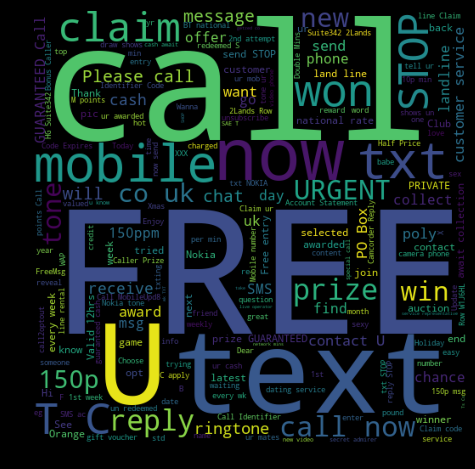

In [4]:
print('Spam Word Cloud')
spam_words = ' '.join(list(df[df.Label == 'spam']['Asunto']))
spam_wc = WordCloud(width=512, height = 512).generate(spam_words)
plt.figure(figsize = (10,8), facecolor = 'k')
plt.imshow(spam_wc)
plt.show()

Ham Word Cloud


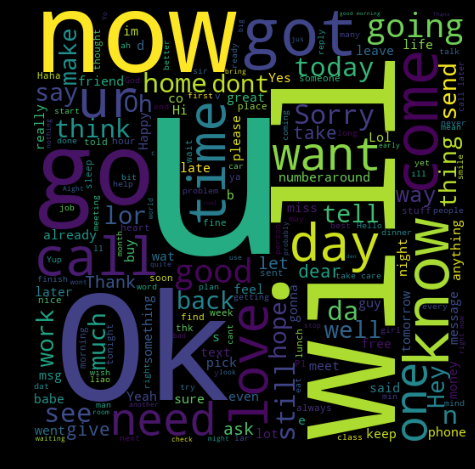

In [5]:
print('Ham Word Cloud')
spam_words = ' '.join(list(df[df.Label == 'ham']['Asunto']))
spam_wc = WordCloud(width=512, height = 512).generate(spam_words)
plt.figure(figsize = (10,8), facecolor = 'k')
plt.imshow(spam_wc)
plt.show()

## Data Cleaning and preporcessing

In [6]:
#from statistics import median_grouped
from nltk import stem
from nltk.corpus import stopwords
import re
import string

stemmer = stem.SnowballStemmer('english')
stop_word = set(stopwords.words('english'))

def text_cleaning(msg):
    # quitar stop words
    msg = [word for word in msg.split() if word not in stop_word]
    # usar un stemmer para misma semántica
    msg = " ".join([stemmer.stem(word) for word in msg])
    # quitando números 
    msg = re.sub(r'\d+','',msg)
    # quitar signos de puntuación
    msg = msg.translate(msg.maketrans("","",string.punctuation))
    return msg

df['Asunto'] = df.Asunto.apply(text_cleaning)

## Naive Bayes Classifier

Spliting Data

In [7]:
# dataset aleatorio
data_randomized = df.sample(frac = 1, random_state = 1)

# realizar un index para la separación 
training_test_index = round(len(data_randomized) * .8 )

# separar para entrenamiento y prueba
train = data_randomized[:training_test_index].reset_index(drop= True)
test = data_randomized[training_test_index:].reset_index(drop = True)

print(train.shape)
print(test.shape)

(4447, 2)
(1112, 2)


#### Training: 
Obtaining the probabilies of each word

In [8]:
#todas las palabras en un dict
def all_words(dataset): 
    all_msg = ' '.join([dataset.Asunto.iloc[i] for i in range(len(dataset))])
    words = pd.Series(all_msg.split(' ')).value_counts()[1:] #le quite el dict(), pero se debe converit al llamar la función
    return words

#reesturcturar diccionario con las probabilidades para cada clase
def reset_dict(words, prob_clf):
    words_dict = words
    for i in words_dict:
        if i in prob_clf.index:
            words_dict[i] = prob_clf[i]
        else:
            words_dict[i] = 1 #Laplace smoothing in Naïve Bayes algorithm
    return words_dict

#probabilidades de cada palabra set de spam y ham
def spam_clf_prob(dataset):
    dict_words_spam = dict(all_words(dataset))
    dict_words_ham = dict(all_words(dataset))
    
    words_spam = all_words(dataset[dataset.Label == 'spam'])
    prob_spam = words_spam/sum(words_spam)
    spam_dict = reset_dict(dict_words_spam, prob_spam)

    words_ham = all_words(dataset[dataset.Label == 'ham'])
    prob_ham = words_ham/sum(words_ham)
    ham_dict = reset_dict(dict_words_ham, prob_ham)

    return spam_dict, ham_dict

In [9]:
#Corregir las funciones para que de valor diferente entre el ham y spam
spam, ham = spam_clf_prob(train)

#### Testing:
Obteining classification, based on probability dicts

In [10]:
def Navie_bayes(msg, p_spams, p_hams):
    spam_bayes = 1
    ham_bayes = 1
    for i in msg:
        if i in p_spams.keys():
            spam_bayes = spam_bayes * p_spams[i]
        elif i in p_hams.keys():
            ham_bayes = ham_bayes * p_hams[i]
        else:
            continue
    
    #spam_bayes
    return 'ham' if spam_bayes < ham_bayes else 'spam'

test['label_pred'] = [Navie_bayes(i.split(' '), spam, ham) for i in test.Asunto]

Confusión Matrix

In [11]:
def conf_matrix(y, y_pred):
    TP = 0
    FP = 0
    TN = 0
    FN = 0

    for i in range(len(y)):
        if y[i] == 'spam':
            if y[i] == y_pred[i]:
                TP += 1
            else:
                FN += 1
   
        else:
            if y[i] == y_pred[i]:
                TN += 1
            else:
                FP += 1

    print('Accuracy: ', (TP + TN) / (TP + TN + FP + FN))
    print('Precision: ', TP / (TP + FP))
    print('Sensitivity: ', (TP) / (TP + FN))
    print('Specificity: ', (TN) / (TN + FP))

conf_matrix(test.Label, test.label_pred)

Accuracy:  0.835431654676259
Precision:  0.03571428571428571
Sensitivity:  0.006369426751592357
Specificity:  0.9717277486910995


Try it yourself! :)

In [12]:
print('Enter your subject in the text box')
print('The message is: ', Navie_bayes(input(str).split(' '), spam, ham)) 

Enter your subject in the text box
The message is:  ham
